<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/famous_place_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 名所・旧跡

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
df_tourist_org = pd.read_csv(os.path.join(DIR_NAME, 'tourist_worship_nearby.csv'))
print(df_tourist_org.shape)

(14983, 7)


In [6]:
df_tourist_org['types_list'] = df_tourist_org['types'].apply(lambda x: x.replace('"', '').replace('[', '').replace(']', '').replace("'", '').replace(' ', '').split(','))
types_list = df_tourist_org['types_list'].explode()

In [7]:
types_list.value_counts().head(25)

point_of_interest     14983
establishment         14983
tourist_attraction     4880
park                   2753
store                   840
food                    672
place_of_worship        625
health                  584
parking                 464
restaurant              365
museum                  304
general_contractor      222
transit_station         208
school                  170
finance                 168
hair_care               152
atm                     119
real_estate_agency      118
storage                 113
home_goods_store        109
cafe                     77
laundry                  68
doctor                   64
beauty_salon             64
clothing_store           63
Name: types_list, dtype: int64

In [8]:
df_tourist_org['施設分類'] = None

In [9]:
df_tourist_org.loc[df_tourist_org['types_list'].apply(lambda x: 'park' in x), '施設分類'] = '公園'
for place in ['公園', '広場', '遊園', '遊園地', '緑地']:
    df_tourist_org.loc[df_tourist_org['name'].str.endswith(place), '施設分類'] = '公園'

In [10]:
conv_worship_place = {
    '寺': '寺',
    '院': '寺',
    '地蔵': '寺',
    '観音': '寺',
    '不動尊': '寺',
    '仏': '寺',
    '天': '寺',
    '堂': '寺',
    '神社': '神社',
    '社': '神社',
    '宮': '神社',
    '稲荷': '神社',
    '教会': '教会',
}

In [11]:
for worship_place in ['寺', '神社', '院', '社', '宮', '教会', '地蔵', '観音', '稲荷', '不動尊', '仏', '天', '堂']:
    df_tourist_org.loc[
        (df_tourist_org['施設分類'].isna()) &
        (df_tourist_org['types_list'].apply(lambda x: 'place_of_worship' in x)) &
        (df_tourist_org['name'].str.contains(worship_place)), '施設分類'
    ] = conv_worship_place[worship_place]

In [12]:
df_tourist_org.loc[
    (df_tourist_org['施設分類'].isna()) &
    ((df_tourist_org['types_list'].apply(lambda x: 'cemetery' in x)) |
     (df_tourist_org['name'].str.endswith('墓')) |
     (df_tourist_org['name'].str.endswith('墓地')) |
     (df_tourist_org['name'].str.endswith('墓所'))
     ), '施設分類'
] = '墓地'

In [13]:
df_tourist_org.loc[
    (df_tourist_org['施設分類'].isna()) &
    (df_tourist_org['types_list'].apply(lambda x: 'museum' in x)), '施設分類'
] = '美術館・博物館'

In [14]:
df_tourist_org.loc[
    (df_tourist_org['施設分類'].isna()) &
    (df_tourist_org['types_list'].apply(lambda x: 'tourist_attraction' in x)) &
    ((df_tourist_org['name'].str.endswith('跡')) |
     (df_tourist_org['name'].str.startswith('旧')) |
     (df_tourist_org['name'].str.endswith('の地')) |
     (df_tourist_org['name'].str.endswith('跡地')) |
     (df_tourist_org['name'].str.endswith('屋敷')) |
     (df_tourist_org['name'].str.contains('史跡')) |
     (df_tourist_org['name'].str.contains('旧跡'))
     ), '施設分類'
] = '旧跡'

In [15]:
df_tourist_org.loc[
    (df_tourist_org['施設分類'].isna()) &
    ((df_tourist_org['name'].str.endswith('街')) |
     (df_tourist_org['name'].str.endswith('横丁')) |
     (df_tourist_org['name'].str.endswith('通り')) |
     (df_tourist_org['name'].str.endswith('新道'))
     ), '施設分類'
] = '通り'

In [16]:
for place in ['並木', '道', '桜']:
    df_tourist_org.loc[
        (df_tourist_org['施設分類'].isna()) &
        (df_tourist_org['types_list'].apply(lambda x: 'tourist_attraction' in x)) &
        (df_tourist_org['name'].str.endswith(place)), '施設分類'
    ] = '並木道'

In [17]:
for place in ['坂', '橋', '古墳', '碑', '像', '湯', '池', '川']:
    df_tourist_org.loc[
        (df_tourist_org['施設分類'].isna()) &
        (df_tourist_org['types_list'].apply(lambda x: 'tourist_attraction' in x)) &
        (df_tourist_org['name'].str.endswith(place)), '施設分類'
    ] = place

In [18]:
df_tourist_org['施設分類'].value_counts()

公園         2866
寺           365
美術館・博物館     303
旧跡          253
神社          194
坂           161
橋           156
碑           112
通り           58
墓地           57
並木道          45
像            41
教会           24
湯            18
池            18
古墳            7
川             5
Name: 施設分類, dtype: int64

In [19]:
df_place_master = df_tourist_org[
    (df_tourist_org['施設分類'].isin(['寺', '神社', '旧跡', '並木道', '橋', '墓地']))
].rename(columns={
    'name': '名称',
    'vicinity': '住所',
    'lat': '緯度',
    'lng': '経度',
})[[
    '名称', '住所', '緯度', '経度', '施設分類', 'rating'
]].reset_index(drop=True)
print(df_place_master.shape)

(1070, 6)


In [20]:
df_place_master.to_csv(os.path.join(DIR_NAME, 'famous_place_master.csv'), index=False, encoding='utf-8_sig')

### 地理マスタ

In [21]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [22]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            pass # print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

In [23]:
place_types = ['寺', '神社', '旧跡', '並木道', '橋', '墓地']

In [24]:
%%time
for place in place_types:
    radius = 0.5
    # 0.5km以内の施設の数
    df_geo_master[f'{place}(数)'] = get_value_of_nearest_facility(df_geo_master, df_place_master, place, 'count', radius)

CPU times: user 46.5 s, sys: 595 ms, total: 47.1 s
Wall time: 54 s


In [25]:
for place in place_types:
    df_geo_master[f'{place}(数)'] = df_geo_master[f'{place}(数)'].fillna(0).astype(int)

In [26]:
df_geo_master.head()

,town_id,市区町村名,町名,町丁目,緯度,経度,寺(数),神社(数),旧跡(数),並木道(数),橋(数),墓地(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,0,0,4,0,0,0
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,0,0,5,0,0,0
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0,0,7,0,0,0
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,1,0,4,0,2,0
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,1,0,3,0,2,0


In [27]:
feature_list = [col for col in df_geo_master.columns if col.endswith(')')]

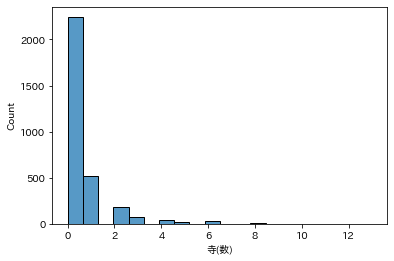

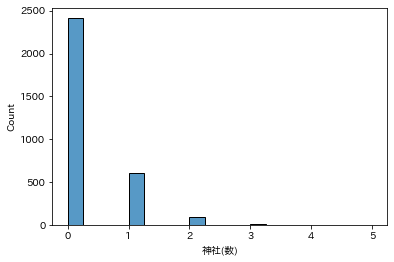

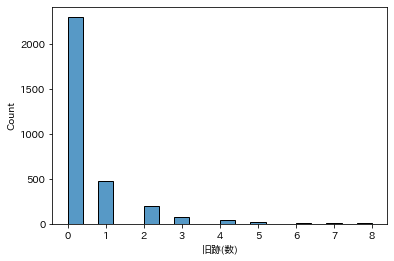

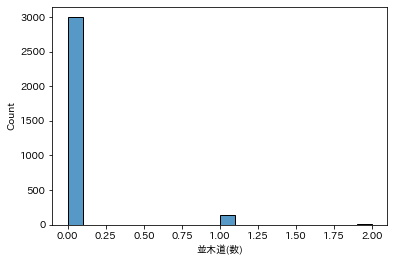

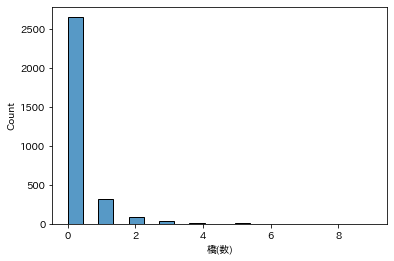

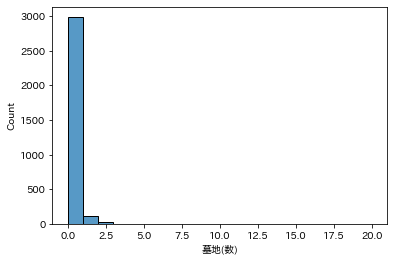

In [28]:
for feature in feature_list:
    sns.histplot(df_geo_master[feature], bins=20)
    plt.show()

In [29]:
df_geo_master[['town_id'] + feature_list].to_csv(os.path.join(DIR_NAME, 'famous_place_score.csv'), index=False, encoding='utf-8_sig')